## Практика 8: Класифікація.

### Приклад 1.

Див. посилання [тут](https://duttashi.github.io/blog/splitting-a-data-frame-into-training-and-testing-sets-in-r/) і
[тут](https://www.analyticsvidhya.com/blog/2021/08/a-brief-introduction-to-linear-discriminant-analysis/).

Якщо ще не встановлені, встановимо наступні пакети та завантажимо бібліотеки.

In [ ]:
library(MASS)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
install.packages("e1071")
install.packages("caTools")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [ ]:
library(e1071)
library(caTools)
# library(caret)

In [ ]:
library(ggplot2)

### Приклад 1.

Завантажимо таблицю, в якій наведені вимірювання 2х типів жуків (для простоти позначимо вимірювання через колонки V3--V6).

In [ ]:
beetles <- read.table('/content/drive/MyDrive/RScripts/T5_5_FBEETLES.DAT',
   col.names = c('Measurement.Number','Species','V3','V4','V5','V6'))
head(beetles)

,Measurement.Number,Species,V3,V4,V5,V6
,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,189,245,137,163
2,2,1,192,260,132,217
3,3,1,217,276,141,192
4,4,1,221,299,142,213
5,5,1,171,239,128,158
6,6,1,192,262,147,173


Розділимо цю таблиці на 2 за принципом: якщо  Species = 1, то це перша група, якщо  Species = 2- то друга.

In [ ]:
beetle1 <- beetles[beetles$Species == 1,][,3:6]
beetle2 <- beetles[beetles$Species == 2,][,3:6]

Знайдемо середні значення $\hat{\mu}_1, \hat{\mu}_2$ та зважену коваріацію  
$$
S_{pl} = \frac{(n_1-1)S_1 + (n_2-1)S_2}{n_1+n_2-2}.
$$
Нагадаємо,  що 2 в функції apply означає, що ми сумуємо по стовбчикам.

In [ ]:
n1 <- nrow(beetle1)
n2 <- nrow(beetle2)

beetle1.means <- apply(beetle1, 2, mean)
beetle2.means <- apply(beetle2, 2, mean)

w1 <- (n1 - 1) * var(beetle1)
w2 <- (n2 - 1) * var(beetle2)

sp1 <- (w1 + w2)/(n1 + n2 - 2)

Позначимо через   cutoff середнє значення, за допомогою якого ми будемо визначати, до якої групи належить  випробування:
$(a'(y_1-y_2))^2/|a|^2$
$z_i = a' y_i$
$$
cutoff = \frac{1}{2} (\hat{\mu}_1- \hat{\mu}_2)' S_{pl}^{-1}(\hat{\mu}_1+\hat{\mu}_2)= \frac12 (a' (\hat{\mu}_1+ \hat{\mu}_2)).
$$

In [ ]:
cutoff <- 0.5 * (beetle1.means - beetle2.means) %*% solve(sp1) %*% (beetle1.means + beetle2.means)
cutoff

-15.80538


Обчислюємо
$$
z = (\hat{\mu}_1- \hat{\mu}_2)' S_{pl}^{-1}y.
$$

In [ ]:
(beetle1.means - beetle2.means) %*% solve(sp1) %*% beetle1.means

-8.955378


In [ ]:
(beetle1.means - beetle2.means) %*% solve(sp1) %*% beetle2.means

-22.65539


Якщо  z>cutoff= - 15.81,  то ми класифікуємо спостереження до першої групи, якшо ні- то до другої (якщо $a'\mu_1>a'\mu_2$, як у нащому випадку)

In [ ]:
species.prediction <- apply(beetles[,3:6], 1, function(y)
    {z <- (beetle1.means - beetle2.means) %*% solve(sp1) %*% y
     ifelse(z > cutoff, 1, 2)})

Розглянемо матрицю змішування (confusion matrix), яка показує, наскільки якісно ми віднесли елементи до тієї чи іншої групи.

In [ ]:
table(beetles$Species, species.prediction, dnn = c('Actual Group','Predicted Group'))

            Predicted Group
Actual Group  1  2
           1 19  0
           2  1 19

Ми класифікували вірно всі спостереження, які відносяться до першої групи, але помилково класифікували одне спостереження з другої групи.  Похибка класифікації- це кількість хибних класифікацій поділити на кількість елементів у вибірці.  

In [ ]:
n <- dim(beetles)[1]
n

[1] 39

Тобто $1 / n= 0.02564103$. Як ми бачимо, навіть при малому об'ємі виборки похибка невірної класифікації 2ї групи  є досить малою.

Для того, щоб зробити класифікацію за допомогою вбудованої функції, використаємо функцію lda() з пакету  MASS.

In [ ]:
beetle.lda <- lda(Species ~ .-Measurement.Number, data = beetles)
lda.pred <- predict(beetle.lda)$class
table(beetles$Species, lda.pred, dnn = c('Actual Group','Predicted Group'))

            Predicted Group
Actual Group  1  2
           1 19  0
           2  1 19

In [ ]:
lda.pred

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
[39] 2
Levels: 1 2

Матриця змішання демонструє співвідношення результату  класифікації  та фактичної належності до тієї чи іншої групи.

Виконаємо тепер байєсівську класифікацію. Введемо апріорні ймовірності наступним чином: використаємое відності частоти, тобто  $p1= 19/39$, $p2 = 20/39$.

In [ ]:
p1 <- 19/39
p2 <- 20/39

Визначимо лінійну дискримінантну функцію
$$
L(y) := (\boldsymbol{\mu}_1 -\boldsymbol{\mu}_2)'\Sigma^{-1}\boldsymbol{y}-  \frac{1}{2} (\boldsymbol{\mu}_1 -\boldsymbol{\mu}_2)' \Sigma^{-1} (\boldsymbol{\mu}_1+\boldsymbol{\mu}_2) + \ln \frac{p_2}{p_1}.
$$
За гіпотези $H_0$ :  спостереження у 1й групі. Тоді  $L(y)>0$.

In [ ]:
L <- function(y){ t(beetle1.means-beetle2.means) %*% solve(sp1) %*% y
                 - 0.5* t(beetle1.means-beetle2.means) %*% solve(sp1) %*% (beetle1.means+beetle2.means) + log(p2/p1)}

Введемо тепер вектор і спробуємо його класифікувати:

In [ ]:
y <- c(180,230,140,170)

Обчислимо $L(y)$ (замість $\mu_1$, $\mu_2$, $\Sigma$ підставимо їх оцінки).

In [ ]:
L(y)

15.85668


Оскільки $L(y)>0$, то ви відносимо наше спостеореження до 1ї групи. Зауважимо, що класифікація за допомогої дискримінантної функції дає такий самий результат.

### Приклад 2.

Байєсівська класифікація, Iris

Продемонструємо, як виконати класифікацію на прикладі  Iris dataset. Цей датасет містить три різновиди квітів  (setosa,viriginica,versicolor)
та  4 їх показники (довжина стебла, ширина стебла, довжина пелюстака, ширина пелюстка) (англійсьокою: Sepal.Length, Sepal.Width, Petal.Length, Petal.Width). Ці показники виміряно для кожної квітки.

In [ ]:
data(iris)
head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


Розіб'ємо дані на дві групи: тренувальну та тестову множини. Пропорцію розбиття (SplitRatio) візьмемо
 0.7, тобто з 150 квіток у нас $70\%$ квітів знаходиться в тренувальній множині, а  $30\%$ в тестовій.

In [ ]:
iris$spl=sample.split(iris,SplitRatio=0.7)
iris$spl

[1]  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE
 [13]  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE
 [25] FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE
 [37] FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE
 [49]  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE
 [61]  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE
 [73]  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE
 [85] FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE
 [97] FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE
[109]  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE
[121]  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE
[133]  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE
[145] FALSE  TRUE FALSE  TRUE  TRUE FALSE

Визначимо тепер ці тестові і тренувальні множини.

In [ ]:
train=subset(iris, iris$spl==TRUE)
head(train)

test=subset(iris, iris$spl==FALSE)
head(test)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,spl
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
1,5.1,3.5,1.4,0.2,setosa,TRUE
3,4.7,3.2,1.3,0.2,setosa,TRUE
4,4.6,3.1,1.5,0.2,setosa,TRUE
6,5.4,3.9,1.7,0.4,setosa,TRUE
8,5.0,3.4,1.5,0.2,setosa,TRUE
9,4.4,2.9,1.4,0.2,setosa,TRUE


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,spl
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
2,4.9,3.0,1.4,0.2,setosa,FALSE
5,5.0,3.6,1.4,0.2,setosa,FALSE
7,4.6,3.4,1.4,0.3,setosa,FALSE
10,4.9,3.1,1.5,0.1,setosa,FALSE
12,4.8,3.4,1.6,0.2,setosa,FALSE
15,5.8,4.0,1.2,0.2,setosa,FALSE


Цю ж поцедуру можна було зробити наступним чином:

In [ ]:
split <- sample.split(iris, SplitRatio = 0.7)
split
train_cl <- subset(iris, split == "TRUE")
test_cl <- subset(iris, split == "FALSE")

[1]  TRUE  TRUE  TRUE FALSE FALSE  TRUE

Застосуємо тепер байєсівську модель класифікації. Якщо не визначено окремо, ми припускаємо, що дані нормально розподілені.
Спочатку ми навчаємо нашу модель на тренувальній множині.

In [ ]:
set.seed(120)
classifier_cl <- naiveBayes(Species ~ ., data = train_cl)
classifier_cl


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
    setosa versicolor  virginica 
      0.34       0.33       0.33 

Conditional probabilities:
            Sepal.Length
Y                [,1]      [,2]
  setosa     4.964706 0.3691779
  versicolor 5.936364 0.4827125
  virginica  6.515152 0.5534670

            Sepal.Width
Y                [,1]      [,2]
  setosa     3.364706 0.3600356
  versicolor 2.769697 0.3254659
  virginica  2.951515 0.3153581

            Petal.Length
Y                [,1]      [,2]
  setosa     1.479412 0.1871305
  versicolor 4.296970 0.4496421
  virginica  5.487879 0.4846117

            Petal.Width
Y                 [,1]      [,2]
  setosa     0.2470588 0.1134455
  versicolor 1.3393939 0.1951592
  virginica  1.9969697 0.2833779

            spl
Y                FALSE      TRUE
  setosa     0.3823529 0.6176471
  versicolor 0.3939394 0.6060606
  virginica  0.4242424 0.5757576


Насправді, те, що називається умовними ймовірностями (conditional probabilities)- це середні значення (перша колонка) та стандартні
відхилення (друга колонка). За відсутності інших припущень, модель розраховується за припущенням, того що дані нормально розподілені.

Обчислимо матрицю невідповідностей:

In [ ]:
y_pred1 <- predict(classifier_cl, newdata = test_cl)
cm1 <- table(test_cl$Species, y_pred1)
cm1

            y_pred1
             setosa versicolor virginica
  setosa         18          0         0
  versicolor      0         16         0
  virginica       0          1        15

Отже, майже всі спостереження  класифіковані правильно.

Якщо ми не знаємо розподіл, то ми можемо застостовувати ядерні оцінки щільності для того, щоб оцінити ці щільності. Оберемо, наприклад, трикутне ядро.

In [ ]:
classifier2_cl <- naiveBayes(Species ~ ., data = train_cl,usekernel=TRUE,
                            kernel="triangular" )
classifier2_cl


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace, usekernel = TRUE, 
    kernel = "triangular")

A-priori probabilities:
Y
    setosa versicolor  virginica 
      0.34       0.33       0.33 

Conditional probabilities:
            Sepal.Length
Y                [,1]      [,2]
  setosa     4.964706 0.3691779
  versicolor 5.936364 0.4827125
  virginica  6.515152 0.5534670

            Sepal.Width
Y                [,1]      [,2]
  setosa     3.364706 0.3600356
  versicolor 2.769697 0.3254659
  virginica  2.951515 0.3153581

            Petal.Length
Y                [,1]      [,2]
  setosa     1.479412 0.1871305
  versicolor 4.296970 0.4496421
  virginica  5.487879 0.4846117

            Petal.Width
Y                 [,1]      [,2]
  setosa     0.2470588 0.1134455
  versicolor 1.3393939 0.1951592
  virginica  1.9969697 0.2833779

            spl
Y                FALSE      TRUE
  setosa     0.3823529 0.6176471
  versicolor 0.3939394 0

Зробимо прогноз, використовуючи теству частину, і порівняємо з (тобто з тими фактичними належностями до класу).

In [ ]:
y_pred2 <- predict(classifier_cl, newdata = test_cl)
y_pred2

[1] setosa     setosa     setosa     setosa     setosa     setosa    
 [7] setosa     setosa     setosa     setosa     setosa     setosa    
[13] setosa     setosa     setosa     setosa     versicolor virginica 
[19] versicolor versicolor versicolor versicolor versicolor virginica 
[25] versicolor versicolor versicolor versicolor versicolor versicolor
[31] versicolor versicolor versicolor virginica  virginica  versicolor
[37] virginica  virginica  virginica  virginica  virginica  virginica 
[43] virginica  virginica  virginica  virginica  virginica  virginica 
[49] virginica  virginica 
Levels: setosa versicolor virginica

Побудуємо матрицю невідповідностей.

In [ ]:
cm2 <- table(test_cl$Species, y_pred2)
cm2

            y_pred2
             setosa versicolor virginica
  setosa         16          0         0
  versicolor      0         15         2
  virginica       0          1        16

Як ми бачимо, ми правильно класифікували setosa, але 2 квітки versicolor ми помилково класифікували до virginica, і
2 квітки virginica-- до versicolor.

Розглянемо ще питання, як апроксимувати ймовірнісну щільність (див. також Додатокв кінці файлу). Для цього розглянемо приклад даних про шоломи гравців в футбол і візьмемо одну координату.

In [ ]:
Foot<-read.table('/content/drive/MyDrive/RScripts/T8_3_FOOTBALL.DAT', col.names = c('Group', 'V2', 'V3', 'V4', 'V5', 'V6','V7') )
head(Foot)
x<- Foot$V2
head(x)


,Group,V2,V3,V4,V5,V6,V7
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,13.5,57.15,19.5,12.5,14.0,11
2,1,15.5,58.42,21.0,12.0,16.0,12
3,1,14.5,55.88,19.0,10.0,13.0,12
4,1,15.5,58.42,20.0,13.5,15.0,12
5,1,14.5,58.42,20.0,13.0,15.5,12
6,1,14.0,60.96,21.0,12.0,14.0,13


[1] 13.5 15.5 14.5 15.5 14.5 14.0

Див. https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/density

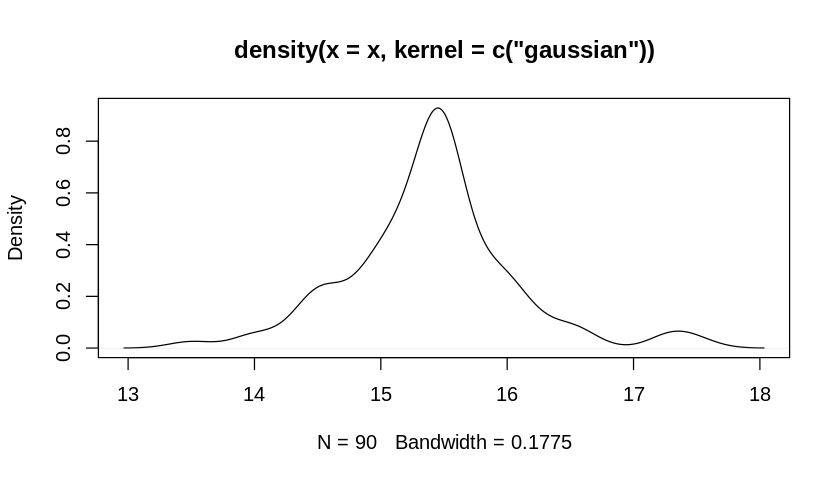

In [ ]:
options(repr.plot.width=7, repr.plot.height=4)
den<-density(x,  kernel = c("gaussian"))
plot(den)

Ми обрали "gaussian", але можна обрати і будь-який з множини "gaussian", "epanechnikov", "rectangular","triangular", "biweight",  "cosine", "optcosine". Як ми бачимо, гаусівське ядро непогано апроксимує щільінсть. Наприклад, оберемо
"rectangular".

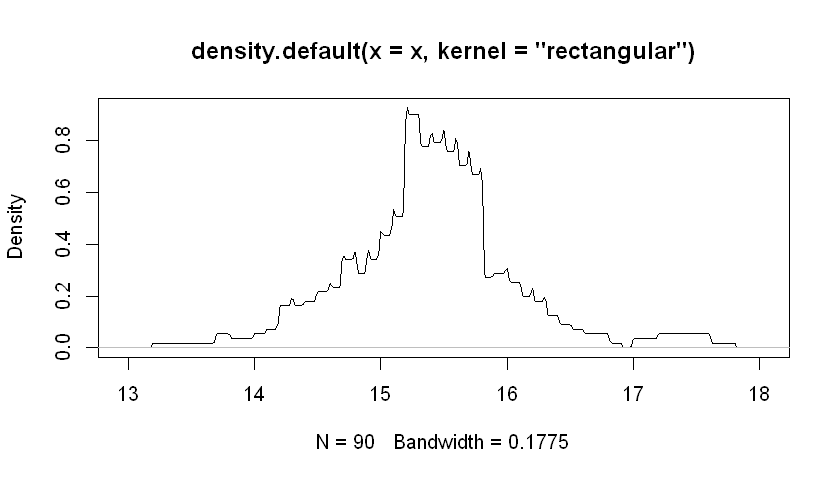

In [ ]:
den2<-density(x,  kernel = "rectangular")

plot(den2)

Перше наближення було явно кращим.

Детальніше про  те, як будувати оцінку щільності "вручну",  можна почитати [тут](https://stackoverflow.com/questions/28077500/find-the-probability-density-of-a-new-data-point-using-density-function-in-r).

## Додаток.


Нехай
$\xi$ має щільність розподілу $f(y)$, та нехай  $N(y_0)$- кількість спостережень, що попали в інтервал  $(y_0-h, y_0+h)$.   Оскільки
$$
\int_{y_0-h}^{y_0+h}  f(z)dz=
P( y_0-h<\xi\leq y_0+h) \asymp \frac{N(y_0)}{n},
$$
то  
$$
\hat{f}(y_0) \asymp  \frac{N(y_0)}{2hn}.
$$
Наша задача- оцінити  
$N(y)$ за допомогою ядра $K(y)$, тому такі оцінки щільності називаються ядерними.

Нехай
$$
K(u) =
\begin{cases}
	\frac{1}{2}, & |u|\leq 1; \\
	0, & |u|>1.
\end{cases}
$$
 Тоді
 $$
 N(y_0)= 2 \sum_{i=1}^n K \left(\frac{y_0-y_i}{h}\right)
 $$
 підраховує кількість точок, які попали в інтервал $y_0-h\leq y_i \leq y_0+h$
 (якщо $|y_i-y_0|\leq h$, то це як раз і означає, що точка $y_i$ попала в інтервал $y_0-h\leq y_i \leq y_0+h$).
Тоді
$$
\hat{f} (y_0)= \frac{1}{nh} \sum_{i=1}^n K \left(\frac{y_0-y_i}{h}\right).
$$
Можні обирати і інші ядра. Наведемо кілька прикладів.

Ядро Єпанчикова:
$$
K(u)= \frac{3}{4} (1-x^2)1_{|x|\leq 1};
$$
Трикутне ядро:
$$
K(u)= (1-|u|) 1_{|u|\leq 1}.
$$
Гаусівске ядро:
$$
 K(u) = \frac{e^{-u^2/2}}{\sqrt{2\pi}}.
$$
І ще одне ядро:
$$
K(u)= \frac{1}{\pi} \frac{\sin^2 u}{u^2}.
$$

У багатовимірному випадку оцінка щільності виглядає наступним чином:
$$
\hat{f}(y_0)= \frac{1}{n h_1 h_2\dots h_p}  \sum_{i=1}^n K \left(
\frac{y_{01}- y_{i1}}{h_1}, \frac{y_{02}- y_{i2}}{h_1}, \dots, \frac{y_{0p}- y_{ip}}{h_1}\right).
$$